In [ ]:
!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 118.8 GB  | Proc size: 514.5 MB
GPU RAM Free: 15364MB | Used: 806MB | Util   5% | Total 16376MB


In [4]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5, ))]
    )
    trainset = MNIST("./dataset", train=True, download=True, transform=transform)
    testset = MNIST("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

In [12]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [14]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [15]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [16]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 17:27:57,991	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 72806533735.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 35488514457.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=9116) Training time for Client 0: 28.06 seconds
(ClientAppActor pid=40336) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 27.969368934631348and 2habhhahah
this is tehb mode time [27.97]
This is ths last time not a fantasy 25.757352352142334and 6habhhahah
this is tehb mode time [27.97, 25.76]
This is ths last time not a fantasy 25.890352964401245and 1habhhahah
this is tehb mode time [27.97, 25.76, 25.89]
This is ths last time not a fantasy 25.563352346420288and 5habhhahah
this is tehb mode time [27.97, 25.76, 25.89, 25.56]
This is ths last time not a fantasy 25.336349964141846and 9habhhahah
this is tehb mode time [27.97, 25.76, 25.89, 25.56, 25.34]
This is ths last time not a fantasy 25.482350826263428and 7habhhahah
this is tehb mode time [27.97, 25.76, 25.89, 25.56, 25.34, 25.48]
This is ths last time not a fantasy 25.594351530075073and 8habhhahah
this is tehb mode time [27.97, 25.76, 25.89, 25.56, 25.34, 25.48, 25.59]
This is ths last time not a fantasy 28.064367294311523and 0habhhahah
this is tehb mode time [27.97, 25.76, 25.89, 25.56, 25.34, 25.48, 25.59, 28.06]
This

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=22836) Training time for Client 3: 24.50 seconds


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40336) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.622629404067993and 5habhhahah
this is tehb mode time [22.62]
This is ths last time not a fantasy 22.672629833221436and 6habhhahah
this is tehb mode time [22.62, 22.67]
This is ths last time not a fantasy 22.609928607940674and 0habhhahah
this is tehb mode time [22.62, 22.67, 22.61]
This is ths last time not a fantasy 22.982863664627075and 8habhhahah
this is tehb mode time [22.62, 22.67, 22.61, 22.98]
This is ths last time not a fantasy 22.917430639266968and 1habhhahah
this is tehb mode time [22.62, 22.67, 22.61, 22.98, 22.92]
This is ths last time not a fantasy 22.66170310974121and 7habhhahah
this is tehb mode time [22.62, 22.67, 22.61, 22.98, 22.92, 22.66]
This is ths last time not a fantasy 25.30442786216736and 9habhhahah
this is tehb mode time [22.62, 22.67, 22.61, 22.98, 22.92, 22.66, 25.3]
This is ths last time not a fantasy 24.625023365020752and 4habhhahah
this is tehb mode time [22.62, 22.67, 22.61, 22.98, 22.92, 22.66, 25.3, 24.63]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22836) [Client 5] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 25.26405096054077and 0habhhahah
this is tehb mode time [25.26]
This is ths last time not a fantasy 24.4584858417511and 3habhhahah
this is tehb mode time [25.26, 24.46]
This is ths last time not a fantasy 23.003981828689575and 8habhhahah
this is tehb mode time [25.26, 24.46, 23.0]
This is ths last time not a fantasy 22.32645034790039and 4habhhahah
this is tehb mode time [25.26, 24.46, 23.0, 22.33]
This is ths last time not a fantasy 22.750795125961304and 1habhhahah
this is tehb mode time [25.26, 24.46, 23.0, 22.33, 22.75]
This is ths last time not a fantasy 23.631981372833252and 7habhhahah
this is tehb mode time [25.26, 24.46, 23.0, 22.33, 22.75, 23.63]
This is ths last time not a fantasy 25.117820739746094and 2habhhahah
this is tehb mode time [25.26, 24.46, 23.0, 22.33, 22.75, 23.63, 25.12]
This is ths last time not a fantasy 22.95698046684265and 9habhhahah
this is tehb mode time [25.26, 24.46, 23.0, 22.33, 22.75, 23.63, 25.12, 22.96]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40336) Training time for Client 6: 24.83 seconds
(ClientAppActor pid=40336) Epoch 8: train loss 0.000528, accuracy 0.994815 [repeated 4x across cluster]
(ClientAppActor pid=22836) [Client 6] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.736541271209717and 1habhhahah
this is tehb mode time [22.74]
This is ths last time not a fantasy 22.79654097557068and 7habhhahah
this is tehb mode time [22.74, 22.8]
This is ths last time not a fantasy 22.77753973007202and 8habhhahah
this is tehb mode time [22.74, 22.8, 22.78]
This is ths last time not a fantasy 22.772541046142578and 3habhhahah
this is tehb mode time [22.74, 22.8, 22.78, 22.77]
This is ths last time not a fantasy 25.94704508781433and 4habhhahah
this is tehb mode time [22.74, 22.8, 22.78, 22.77, 25.95]
This is ths last time not a fantasy 22.79916214942932and 0habhhahah
this is tehb mode time [22.74, 22.8, 22.78, 22.77, 25.95, 22.8]
This is ths last time not a fantasy 24.909648656845093and 5habhhahah
this is tehb mode time [22.74, 22.8, 22.78, 22.77, 25.95, 22.8, 24.91]
This is ths last time not a fantasy 22.6708824634552and 2habhhahah
this is tehb mode time [22.74, 22.8, 22.78, 22.77, 25.95, 22.8, 24.91, 22.67]
This is ths last tim

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=37796) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 24.963178157806396and 2habhhahah
this is tehb mode time [24.96]
This is ths last time not a fantasy 25.27638077735901and 3habhhahah
this is tehb mode time [24.96, 25.28]
This is ths last time not a fantasy 25.74272584915161and 1habhhahah
this is tehb mode time [24.96, 25.28, 25.74]
This is ths last time not a fantasy 25.156176328659058and 0habhhahah
this is tehb mode time [24.96, 25.28, 25.74, 25.16]
This is ths last time not a fantasy 22.653522491455078and 4habhhahah
this is tehb mode time [24.96, 25.28, 25.74, 25.16, 22.65]
This is ths last time not a fantasy 25.32372236251831and 7habhhahah
this is tehb mode time [24.96, 25.28, 25.74, 25.16, 22.65, 25.32]
This is ths last time not a fantasy 25.825483798980713and 6habhhahah
this is tehb mode time [24.96, 25.28, 25.74, 25.16, 22.65, 25.32, 25.83]
This is ths last time not a fantasy 26.218379020690918and 8habhhahah
this is tehb mode time [24.96, 25.28, 25.74, 25.16, 22.65, 25.32, 25.83, 26.22]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=40336) [Client 9] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.796396255493164and 7habhhahah
this is tehb mode time [22.8]
This is ths last time not a fantasy 24.849296808242798and 9habhhahah
this is tehb mode time [22.8, 24.85]
This is ths last time not a fantasy 23.1683988571167and 8habhhahah
this is tehb mode time [22.8, 24.85, 23.17]
This is ths last time not a fantasy 22.776397466659546and 0habhhahah
this is tehb mode time [22.8, 24.85, 23.17, 22.78]
This is ths last time not a fantasy 22.65265154838562and 2habhhahah
this is tehb mode time [22.8, 24.85, 23.17, 22.78, 22.65]
This is ths last time not a fantasy 23.0603985786438and 6habhhahah
this is tehb mode time [22.8, 24.85, 23.17, 22.78, 22.65, 23.06]
This is ths last time not a fantasy 22.58539915084839and 4habhhahah
this is tehb mode time [22.8, 24.85, 23.17, 22.78, 22.65, 23.06, 22.59]
This is ths last time not a fantasy 24.884528636932373and 5habhhahah
this is tehb mode time [22.8, 24.85, 23.17, 22.78, 22.65, 23.06, 22.59, 24.88]
This is ths last t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=9116) [Client 1] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 23.030314922332764and 9habhhahah
this is tehb mode time [23.03]
This is ths last time not a fantasy 25.04211401939392and 3habhhahah
this is tehb mode time [23.03, 25.04]
This is ths last time not a fantasy 23.138853311538696and 7habhhahah
this is tehb mode time [23.03, 25.04, 23.14]
This is ths last time not a fantasy 23.293312788009644and 2habhhahah
this is tehb mode time [23.03, 25.04, 23.14, 23.29]
This is ths last time not a fantasy 25.18019390106201and 4habhhahah
this is tehb mode time [23.03, 25.04, 23.14, 23.29, 25.18]
This is ths last time not a fantasy 24.935112476348877and 1habhhahah
this is tehb mode time [23.03, 25.04, 23.14, 23.29, 25.18, 24.94]
This is ths last time not a fantasy 23.220303058624268and 8habhhahah
this is tehb mode time [23.03, 25.04, 23.14, 23.29, 25.18, 24.94, 23.22]
This is ths last time not a fantasy 22.47531008720398and 6habhhahah
this is tehb mode time [23.03, 25.04, 23.14, 23.29, 25.18, 24.94, 23.22, 22.48]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36496) Training time for Client 0: 24.88 seconds
(ClientAppActor pid=40336) [Client 7] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.53969931602478and 8habhhahah
this is tehb mode time [22.54]
This is ths last time not a fantasy 22.56867742538452and 3habhhahah
this is tehb mode time [22.54, 22.57]
This is ths last time not a fantasy 25.313578844070435and 6habhhahah
this is tehb mode time [22.54, 22.57, 25.31]
This is ths last time not a fantasy 24.8819100856781and 0habhhahah
this is tehb mode time [22.54, 22.57, 25.31, 24.88]
This is ths last time not a fantasy 22.296696662902832and 2habhhahah
this is tehb mode time [22.54, 22.57, 25.31, 24.88, 22.3]
This is ths last time not a fantasy 23.266701459884644and 7habhhahah
this is tehb mode time [22.54, 22.57, 25.31, 24.88, 22.3, 23.27]
This is ths last time not a fantasy 25.128949642181396and 5habhhahah
this is tehb mode time [22.54, 22.57, 25.31, 24.88, 22.3, 23.27, 25.13]
This is ths last time not a fantasy 23.182077407836914and 9habhhahah
this is tehb mode time [22.54, 22.57, 25.31, 24.88, 22.3, 23.27, 25.13, 23.18]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=25920) Training time for Client 4: 28.48 seconds
(ClientAppActor pid=25920) Epoch 9: train loss 0.000043, accuracy 0.999815 [repeated 4x across cluster]
(ClientAppActor pid=9116) [Client 0] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.651198387145996and 0habhhahah
this is tehb mode time [22.65]
This is ths last time not a fantasy 25.739448308944702and 8habhhahah
this is tehb mode time [22.65, 25.74]
This is ths last time not a fantasy 25.184452533721924and 2habhhahah
this is tehb mode time [22.65, 25.74, 25.18]
This is ths last time not a fantasy 23.30620050430298and 5habhhahah
this is tehb mode time [22.65, 25.74, 25.18, 23.31]
This is ths last time not a fantasy 28.481743812561035and 4habhhahah
this is tehb mode time [22.65, 25.74, 25.18, 23.31, 28.48]
This is ths last time not a fantasy 25.226454257965088and 9habhhahah
this is tehb mode time [22.65, 25.74, 25.18, 23.31, 28.48, 25.23]
This is ths last time not a fantasy 25.1224582195282and 7habhhahah
this is tehb mode time [22.65, 25.74, 25.18, 23.31, 28.48, 25.23, 25.12]
This is ths last time not a fantasy 28.137738943099976and 1habhhahah
this is tehb mode time [22.65, 25.74, 25.18, 23.31, 28.48, 25.23, 25.12, 28.14]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=9116) Training time for Client 3: 25.01 seconds
(ClientAppActor pid=22836) [Client 4] evaluate, config: {}


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 515.33s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.003260608266262958
INFO :      		round 2: 0.0020279643287509923
INFO :      		round 3: 0.0018249472413371752
INFO :      		round 4: 0.001663201157604097
INFO :      		round 5: 0.0016092006796343413
INFO :      		round 6: 0.0014723131566662176
INFO :      		round 7: 0.0015191912929108846
INFO :      		round 8: 0.001545771204566885
INFO :      		round 9: 0.001489973638295538
INFO :      		round 10: 0.001512004874465551
INFO :      


History (loss, distributed):
	round 1: 0.003260608266262958
	round 2: 0.0020279643287509923
	round 3: 0.0018249472413371752
	round 4: 0.001663201157604097
	round 5: 0.0016092006796343413
	round 6: 0.0014723131566662176
	round 7: 0.0015191912929108846
	round 8: 0.001545771204566885
	round 9: 0.001489973638295538
	round 10: 0.001512004874465551

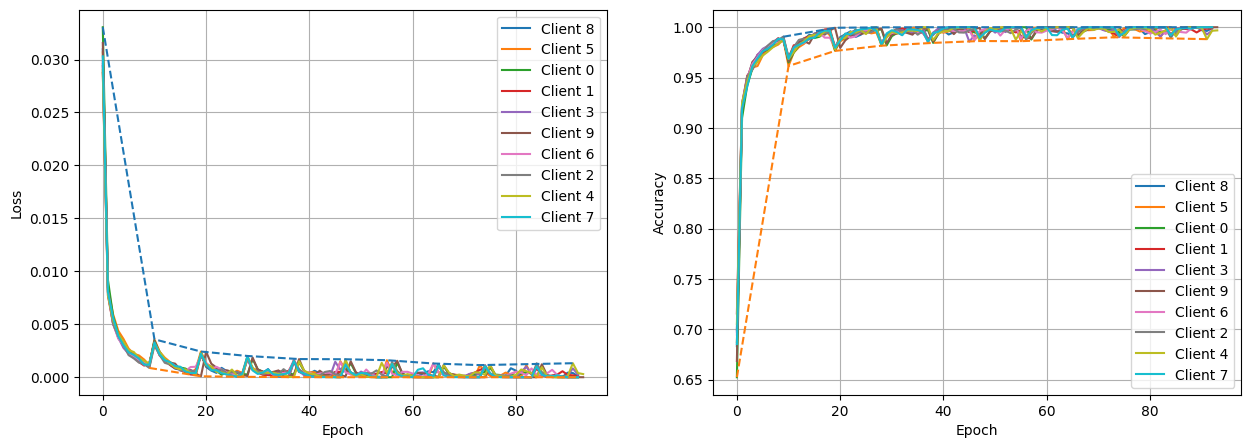

In [17]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

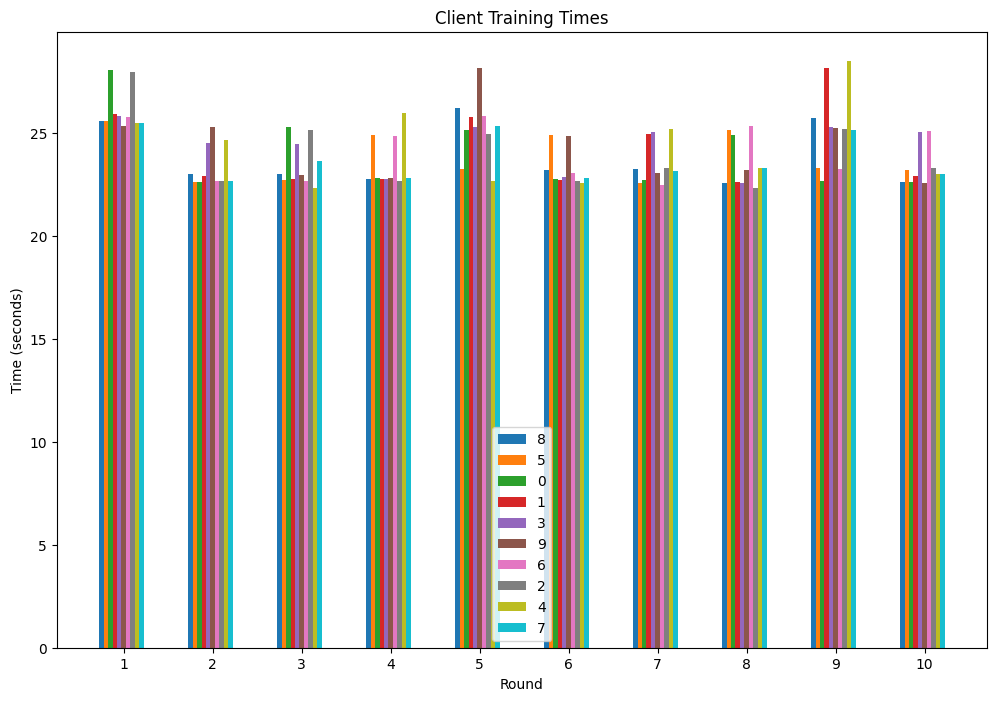

In [18]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [19]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 8 metrics: 93
Client 5 metrics: 91
Client 0 metrics: 93
Client 1 metrics: 93
Client 3 metrics: 93
Client 9 metrics: 94
Client 6 metrics: 92
Client 2 metrics: 93
Client 4 metrics: 94
Client 7 metrics: 93


In [20]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [21]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [22]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 17:36:44,936	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 72908921447.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 35532394905.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8464) [Client 6] get_parameters
(ClientAppActor pid=8464) [Client 9] fit, config: {}
(ClientAppActor pid=8464) Epoch 0: train loss 0.027569, accuracy 0.730370
(ClientAppActor pid=24956) [Client 4] fit, config: {}
(ClientAppActor pid=20812) [Client 2] fit, config: {}
(ClientAppActor pid=8464) Epoch 1: train loss 0.006504, accuracy 0.937407
(ClientAppActor pid=38804) Epoch 0: train loss 0.027804, accuracy 0.707963 [repeated 3x across cluster]
(ClientAppActor pid=26384) [Client 5] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=22656) Epoch 2: train loss 0.004584, accuracy 0.954815 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 4: train loss 0.002704, accuracy 0.970370 [repeated 17x across cluster]
(ClientAppActor pid=22656) Epoch 6: train loss 0.001683, accuracy 0.982778 [repeated 16x across cluster]
(ClientAppActor pid=8464) [Client 3] fit, config: {}
(ClientAppActor pid=22656) Epoch 8: train loss 0.001200, accuracy 0.986667 [repeated

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) Epoch 9: train loss 0.001026, accuracy 0.989074 [repeated 3x across cluster]
(ClientAppActor pid=20812) [Client 4] evaluate, config: {}
(ClientAppActor pid=20812) Client 4 loss 0.0034552832785993814
(ClientAppActor pid=20812) Client 4 accuracy 0.9683333333333334


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8464) [Client 3] fit, config: {}
(ClientAppActor pid=8464) Epoch 1: train loss 0.001837, accuracy 0.982222 [repeated 9x across cluster]
(ClientAppActor pid=8464) [Client 1] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=8464) Client 1 loss 0.0029665217098469535 [repeated 9x across cluster]
(ClientAppActor pid=8464) Client 1 accuracy 0.9716666666666667 [repeated 9x across cluster]
(ClientAppActor pid=26384) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=22656) Epoch 3: train loss 0.001230, accuracy 0.987593 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 5: train loss 0.000686, accuracy 0.994074 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 7: train loss 0.000537, accuracy 0.994815 [repeated 16x across cluster]
(ClientAppActor pid=20812) [Client 4] fit, config: {}
(ClientAppActor pid=20812) Epoch 9: train loss 0.000035, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor p

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) [Client 6] evaluate, config: {}
(ClientAppActor pid=20812) Client 6 loss 0.0014569754267480068
(ClientAppActor pid=20812) Client 6 accuracy 0.9883333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38804) [Client 6] fit, config: {}
(ClientAppActor pid=38804) Epoch 0: train loss 0.001970, accuracy 0.981296 [repeated 2x across cluster]
(ClientAppActor pid=38804) [Client 7] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=38804) Client 7 loss 0.0015181118463927607 [repeated 9x across cluster]
(ClientAppActor pid=38804) Client 7 accuracy 0.99 [repeated 9x across cluster]
(ClientAppActor pid=6040) [Client 9] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=38804) Epoch 2: train loss 0.000739, accuracy 0.993148 [repeated 17x across cluster]
(ClientAppActor pid=22656) Epoch 4: train loss 0.000476, accuracy 0.995370 [repeated 16x across cluster]
(ClientAppActor pid=38804) Epoch 6: train loss 0.000434, accuracy 0.996481 [repeated 17x across cluster]
(ClientAppActor pid=6040) Epoch 8: train loss 0.000130, accuracy 0.998704 [repeated 17x across cluster]
(ClientAppActor pid=8464) [Client 7] fit, config: {}
(ClientAppActor pid=20812) Ep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) [Client 8] evaluate, config: {}
(ClientAppActor pid=20812) Client 8 loss 0.000746435475157341
(ClientAppActor pid=20812) Client 8 accuracy 0.9933333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8464) [Client 4] fit, config: {}
(ClientAppActor pid=20812) Epoch 9: train loss 0.000142, accuracy 0.998889 [repeated 3x across cluster]
(ClientAppActor pid=8464) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=8464) Client 0 loss 0.0024626835107149723 [repeated 9x across cluster]
(ClientAppActor pid=8464) Client 0 accuracy 0.9866666666666667 [repeated 9x across cluster]
(ClientAppActor pid=26384) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=24956) Epoch 1: train loss 0.000455, accuracy 0.994074 [repeated 13x across cluster]
(ClientAppActor pid=6040) Epoch 3: train loss 0.000500, accuracy 0.993519 [repeated 18x across cluster]
(ClientAppActor pid=6040) Epoch 5: train loss 0.000337, accuracy 0.996667 [repeated 16x across cluster]
(ClientAppActor pid=19680) Epoch 7: train loss 0.000031, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=6040) [Client 8] fit, config: {}
(ClientAppActor pid

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6040) [Client 9] evaluate, config: {}
(ClientAppActor pid=6040) Client 9 loss 0.001271299520200652
(ClientAppActor pid=6040) Client 9 accuracy 0.9916666666666667


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19680) [Client 8] fit, config: {}
(ClientAppActor pid=6040) Epoch 9: train loss 0.000004, accuracy 1.000000 [repeated 3x across cluster]
(ClientAppActor pid=19680) [Client 3] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=19680) Client 3 loss 0.002794803991844219 [repeated 9x across cluster]
(ClientAppActor pid=19680) Client 3 accuracy 0.9833333333333333 [repeated 9x across cluster]
(ClientAppActor pid=20812) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=19680) Epoch 1: train loss 0.000511, accuracy 0.995000 [repeated 10x across cluster]
(ClientAppActor pid=20812) Epoch 3: train loss 0.000226, accuracy 0.998333 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 5: train loss 0.000682, accuracy 0.994074 [repeated 17x across cluster]
(ClientAppActor pid=38804) Epoch 7: train loss 0.000025, accuracy 0.999815 [repeated 17x across cluster]
(ClientAppActor pid=6040) [Client 0] fit, config: {}
(ClientAppActor

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) Epoch 9: train loss 0.000003, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=20812) [Client 2] evaluate, config: {}
(ClientAppActor pid=6040) Client 0 loss 0.0025497271985036227
(ClientAppActor pid=6040) Client 0 accuracy 0.985


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6040) [Client 0] fit, config: {}
(ClientAppActor pid=6040) Epoch 1: train loss 0.000474, accuracy 0.995370 [repeated 9x across cluster]
(ClientAppActor pid=6040) [Client 6] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=6040) Client 6 loss 0.0013625098838095557 [repeated 9x across cluster]
(ClientAppActor pid=6040) Client 6 accuracy 0.99 [repeated 9x across cluster]
(ClientAppActor pid=19680) [Client 1] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=24956) Epoch 3: train loss 0.000186, accuracy 0.998889 [repeated 17x across cluster]
(ClientAppActor pid=22656) Epoch 5: train loss 0.000010, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=24956) Epoch 7: train loss 0.000792, accuracy 0.993519 [repeated 17x across cluster]
(ClientAppActor pid=20812) [Client 5] fit, config: {}
(ClientAppActor pid=22656) Epoch 9: train loss 0.000002, accuracy 1.000000 [repeated 14x across cluster]
(ClientAppActor pid=22656) [Cli

INFO :      aggregate_fit: received 10 results and 0 failures


(ClientAppActor pid=20812) Epoch 9: train loss 0.000776, accuracy 0.993148 [repeated 4x across cluster]


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22656) [Client 7] evaluate, config: {}
(ClientAppActor pid=22656) Client 7 loss 0.0005842528126944065
(ClientAppActor pid=22656) Client 7 accuracy 0.9933333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=6040) [Client 0] fit, config: {}
(ClientAppActor pid=22656) Epoch 1: train loss 0.000410, accuracy 0.995370 [repeated 10x across cluster]
(ClientAppActor pid=6040) [Client 1] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=6040) Client 1 loss 0.0022856327590805373 [repeated 9x across cluster]
(ClientAppActor pid=6040) Client 1 accuracy 0.985 [repeated 9x across cluster]
(ClientAppActor pid=20812) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=26384) Epoch 3: train loss 0.000145, accuracy 0.998148 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 5: train loss 0.000004, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=22656) Epoch 7: train loss 0.000002, accuracy 1.000000 [repeated 15x across cluster]
(ClientAppActor pid=22656) [Client 3] fit, config: {}
(ClientAppActor pid=22656) Epoch 9: train loss 0.000002, accuracy 1.000000 [repeated 16x across cluster]
(ClientAppActor pid=26384) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22656) Epoch 9: train loss 0.000459, accuracy 0.995926 [repeated 4x across cluster]
(ClientAppActor pid=26384) [Client 8] evaluate, config: {}
(ClientAppActor pid=26384) Client 8 loss 0.0007876260372900863
(ClientAppActor pid=26384) Client 8 accuracy 0.995


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38804) [Client 7] fit, config: {}
(ClientAppActor pid=38804) Epoch 1: train loss 0.000351, accuracy 0.995370 [repeated 10x across cluster]
(ClientAppActor pid=38804) [Client 0] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=38804) Client 0 loss 0.0029651782631109095 [repeated 9x across cluster]
(ClientAppActor pid=38804) Client 0 accuracy 0.9866666666666667 [repeated 9x across cluster]
(ClientAppActor pid=22656) [Client 8] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=38804) Epoch 3: train loss 0.000040, accuracy 0.999630 [repeated 16x across cluster]
(ClientAppActor pid=8464) Epoch 5: train loss 0.000005, accuracy 1.000000 [repeated 16x across cluster]
(ClientAppActor pid=8464) Epoch 7: train loss 0.000002, accuracy 1.000000 [repeated 16x across cluster]
(ClientAppActor pid=22656) Epoch 9: train loss 0.000001, accuracy 1.000000 [repeated 16x across cluster]
(ClientAppActor pid=26384) [Client 3] fit, config: {}
(ClientAppAct

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22656) Epoch 9: train loss 0.000002, accuracy 1.000000 [repeated 4x across cluster]
(ClientAppActor pid=26384) [Client 3] evaluate, config: {}
(ClientAppActor pid=26384) Client 3 loss 0.0024304794358313113
(ClientAppActor pid=26384) Client 3 accuracy 0.9833333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) [Client 0] fit, config: {}
(ClientAppActor pid=20812) Epoch 1: train loss 0.000146, accuracy 0.998889 [repeated 10x across cluster]
(ClientAppActor pid=20812) [Client 2] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=20812) Client 2 loss 0.0015997064232279002 [repeated 9x across cluster]
(ClientAppActor pid=20812) Client 2 accuracy 0.9866666666666667 [repeated 9x across cluster]
(ClientAppActor pid=38804) [Client 4] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=24956) Epoch 3: train loss 0.000088, accuracy 0.999259 [repeated 17x across cluster]
(ClientAppActor pid=26384) Epoch 5: train loss 0.000146, accuracy 0.998519 [repeated 16x across cluster]
(ClientAppActor pid=8464) Epoch 7: train loss 0.000002, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppActor pid=26384) [Client 9] fit, config: {}
(ClientAppActor pid=24956) Epoch 9: train loss 0.000001, accuracy 1.000000 [repeated 17x across cluster]
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20812) [Client 0] evaluate, config: {}
(ClientAppActor pid=26384) Client 7 loss 0.00046462354787365714
(ClientAppActor pid=26384) Client 7 accuracy 0.9933333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26384) [Client 1] fit, config: {}
(ClientAppActor pid=19680) Epoch 0: train loss 0.000658, accuracy 0.995000 [repeated 6x across cluster]
(ClientAppActor pid=26384) [Client 8] evaluate, config: {} [repeated 9x across cluster]
(ClientAppActor pid=26384) Client 8 loss 0.000487224048272689 [repeated 9x across cluster]
(ClientAppActor pid=26384) Client 8 accuracy 0.995 [repeated 9x across cluster]
(ClientAppActor pid=38804) [Client 6] fit, config: {} [repeated 7x across cluster]
(ClientAppActor pid=6040) Epoch 2: train loss 0.000103, accuracy 0.999074 [repeated 15x across cluster]
(ClientAppActor pid=20812) Epoch 4: train loss 0.000084, accuracy 0.999630 [repeated 16x across cluster]
(ClientAppActor pid=20812) Epoch 6: train loss 0.000559, accuracy 0.995556 [repeated 16x across cluster]
(ClientAppActor pid=6040) Epoch 8: train loss 0.000002, accuracy 1.000000 [repeated 16x across cluster]
(ClientAppActor pid=8464) [Client 9] fit, config: {}
(ClientAppActor pid=8464) Epo

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=8464) [Client 6] evaluate, config: {}
(ClientAppActor pid=8464) Client 6 loss 0.0020465941375376437
(ClientAppActor pid=8464) Client 6 accuracy 0.9933333333333333


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 558.82s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.003330679993455609
INFO :      		round 2: 0.001780827835906166
INFO :      		round 3: 0.0016469445301050124
INFO :      		round 4: 0.001748289471201057
INFO :      		round 5: 0.0015146020075476941
INFO :      		round 6: 0.001528518316414614
INFO :      		round 7: 0.00169149734970198
INFO :      		round 8: 0.001658100503898427
INFO :      		round 9: 0.0015367278811592988
INFO :      		round 10: 0.0016877898514150217
INFO :      


History (loss, distributed):
	round 1: 0.003330679993455609
	round 2: 0.001780827835906166
	round 3: 0.0016469445301050124
	round 4: 0.001748289471201057
	round 5: 0.0015146020075476941
	round 6: 0.001528518316414614
	round 7: 0.00169149734970198
	round 8: 0.001658100503898427
	round 9: 0.0015367278811592988
	round 10: 0.0016877898514150217

(ClientAppActor pid=26384) Client 0 loss 0.002967246457714493
(ClientAppActor pid=26384) Client 0 accuracy 0.9866666666666667


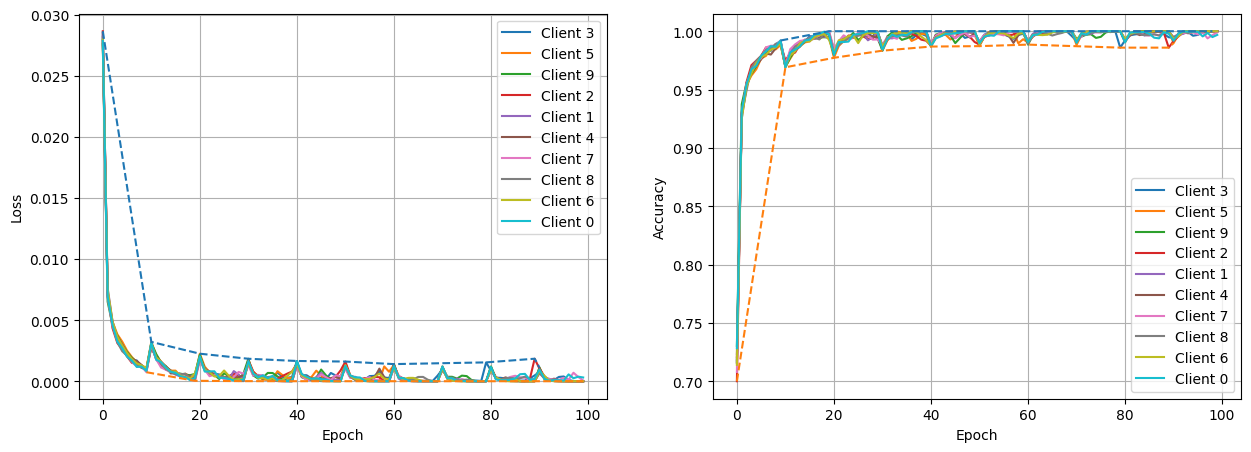

In [23]:
plot_metrics(strategy_fed_avg.client_metrics)

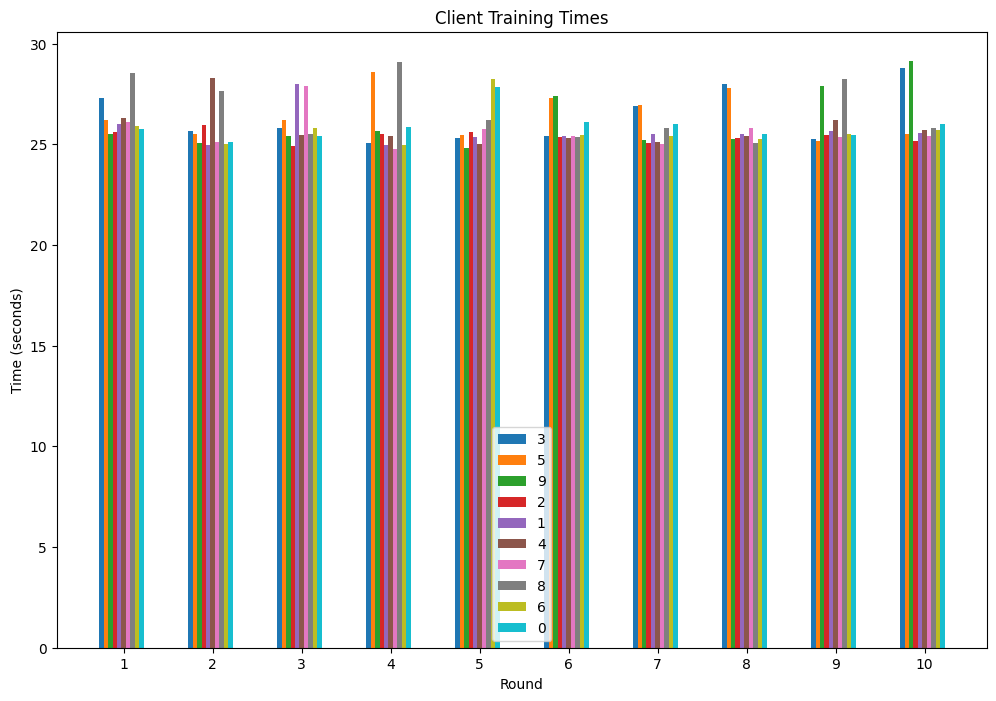

In [24]:
plot_times(strategy_fed_avg.client_training_times)